In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as scio
from sklearn.cluster import KMeans 

In [2]:
def quantizeFeats(featIm,meanFeats):
    '''
    input: 
        featIm: a matrix with shape h*w*d
        meanFeats: the center with shape k*d, which denotes k clusters and d features' mean value
    
    output:
        labelIm: a matrix with shape h*w, which denotes each pixel's label
    '''
    
    h, w, d = featIm.shape
    k = meanFeats.shape[0]
    featIm = featIm.reshape((h*w,d))
    labelIm = np.zeros(h*w)
    for i in range(h*w):
        dis = np.sqrt(np.sum((featIm[i,:]-meanFeats)**2,axis=1))
        labelIm[i] = np.argmin(dis)
    labelIm = np.uint8(labelIm).reshape((h,w))
    return labelIm

In [3]:
def createTextons(imStack,bank,k):
    '''
    input:
        imStack: a list with n grayscale images [im_1,im_2,...,im_n]
        bank: a filter bank with shape m*m*d
        k: cluster number
        
    output:
        textons: a sample of filters response to n images, each shape k*d
    '''
    
    textonCan = []    # prepare the candidates of the textons
    for i,img in enumerate(imStack):
        text = []
        for i in range(bank.shape[2]):
            img1 = cv2.filter2D(img,-1,bank[:,:,i])
            text.append(img1)
        text = np.array(text)
        text = text.reshape((-1,bank.shape[2]))
        textonCan.append(text)
    texton1 = textonCan[0]
    for i in range(1,len(textonCan)):
        texton1 = np.concatenate((texton1,textonCan[i]),axis=0)
    textonCan = texton1
    sample = np.random.choice(textonCan.shape[0],size=10000) # to reduce the complexity, only sample the subset of pixels
    texts = textonCan[sample,:]

    estimator = KMeans(n_clusters=k) # cluster
    estimator.fit(texts)
    textons = estimator.cluster_centers_ # get the textons
    
    return textons

In [4]:
def extractTextonHists(origIm,bank,textons,winSize):
    '''
    input:
        origIm: a grayscale image 
        bank: a filter bank with shape m*m*d
        textons: a sample of filters response to n images, each shape k*d
        winSize: local window scale
    output:
        featIm: a matrix with shape h*w*k
    '''
    
    h,w = origIm.shape
    k = textons.shape[0]
    text = []
    for i in range(bank.shape[2]):
        img1 = cv2.filter2D(origIm,-1,bank[:,:,i])
        text.append(img1)
    text = np.array(text).reshape((bank.shape[2],-1)).T
    textLabel = np.zeros(h*w)
    for i in range(h*w):
        dis = np.sqrt(np.sum((text[i,:]-textons)**2,axis=1))
        textLabel[i] = np.argmin(dis)
    textLabel = np.uint8(textLabel).reshape((h,w))
    
    featIm = np.zeros((h,w,k))
    for i in range(h):
        for j in range(w):
            tmp = textLabel[i-winSize//2:i+winSize//2,j-winSize//2:j+winSize//2]
            for m in tmp.ravel():
                featIm[i,j,m]+=1
                
    return featIm

In [5]:
def compareSegmentations(origIm,bank,textons,winSize,numColorRegions,numTextureRegions):
    '''
    input:
        origIm: the origin image 
        bank: a filter bank with shape m*m*d
        textons: a sample of filters response to n images, each shape k*d
        winSize: local window scale 
        numColorRegions: the number of desired segments for color segmentation
        numTextureRegions: the number of desired segments for texture segmentation
    output:
        colorLabelIm: h*w matrices recording segment labels
        textureLabelIm: h*w matrices recording segment labels
    '''
    h,w,d = origIm.shape
    # color segmentation
    estimator = KMeans(n_clusters=numColorRegions) # cluster
    estimator.fit(origIm.reshape((h*w,-1)))
    colorLabelIm = estimator.predict(origIm.reshape((h*w,-1))).reshape((h,w))
    colorLabelIm = np.uint8(colorLabelIm.reshape((h,w)))
    # texture segmentation
    origIm = cv2.cvtColor(origIm,cv2.COLOR_RGB2GRAY)
    featIm = extractTextonHists(origIm,bank,textons,winSize)
    estimator = KMeans(n_clusters=numTextureRegions) # cluster
    estimator.fit(featIm.reshape((h*w,-1)))
    textureLabelIm = estimator.predict(featIm.reshape((h*w,-1))).reshape((h,w))
    textureLabelIm = np.uint8(textureLabelIm.reshape((h,w)))
    
    return colorLabelIm,textureLabelIm,featIm
    

In [6]:
def show(label):
    '''
    input:
        label: the image's label with shape h*w
    output:
        show: the image with RGB color, shape h*w*3
    
    '''
    n = np.unique(label).size
    show = np.zeros((label.shape[0],label.shape[1],3),dtype=np.uint8)
    for i in range(n):
        show[label==i,:] = np.array([np.random.randint(255),np.random.randint(255),np.random.randint(255)],dtype=np.uint8)
        
    return show

In [7]:
path=r"E:\project\images\researchImage\images\cut\15"
files=os.listdir(path)

In [8]:
filterBank = scio.loadmat(r"E:\homework\ComputerVision\homework\Assignment2\Assignment2\ImageSegmentation\filterBank.mat")
bank = filterBank['F']

In [9]:
sample = np.random.choice(len(files),size=20)
imStack=[]
for i in sample:
    image=cv2.imread(os.path.join(path,files[i]))
    imStack.append(image)

In [10]:
# compare result with different k
def compare(img,k=64,numColorRegions = 10,numTextureRegions = 10, winSize = 5,save=False):
    textons = createTextons(imStack,bank,k)
    origIm = img.copy()
    colorLabelIm,textureLabelIm,featIm=compareSegmentations(origIm,bank,textons,winSize,numColorRegions,numTextureRegions)
    colorLabelShow = show(colorLabelIm)
    textureLabelShow = show(textureLabelIm)
    plt.subplot(121)
    plt.imshow(colorLabelShow)
    plt.subplot(122)
    plt.imshow(textureLabelShow)
    if save==True:
        cv2.imwrite(r"E:\project\images\researchImage\images\labelsets\TextureAndColor\color3.jpg",colorLabelShow)
        cv2.imwrite(r"E:\project\images\researchImage\images\labelsets\TextureAndColor\text3.jpg",textureLabelShow)
    return colorLabelIm,textureLabelIm,featIm

In [11]:
img1=cv2.imread(os.path.join(path,'12_11.tif'))

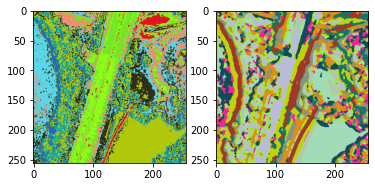

In [12]:
clab,tlab,ftIm=compare(img1)

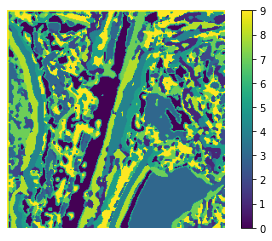

In [13]:
fig = plt.figure()
plt.axis('off')
heatmap = plt.imshow(tlab, cmap='viridis')
fig.colorbar(heatmap)
fig.savefig(r'E:\project\images\researchImage\images\labelsets\TextureAndColor\text3_heatmap.png')

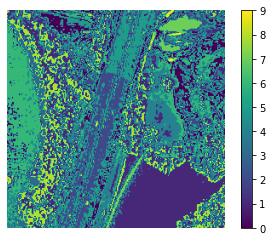

In [14]:
fig = plt.figure()
plt.axis('off')
heatmap = plt.imshow(clab, cmap='viridis')
fig.colorbar(heatmap)
fig.savefig(r'E:\project\images\researchImage\images\labelsets\TextureAndColor\color3_heatmap.png')

In [15]:
def kernelTrans(X, A, kTup): #通过数据计算转换后的核函数
    m,n = shape(X)
    K = mat(zeros((m,1)))
    if kTup[0]=='lin': #线性核函数
        K = X * A.T   
    
    elif kTup[0]=='rbf':#高斯核
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = deltaRow*deltaRow.T
        K = exp(K/(-1*kTup[1]**2)) 
 
    elif kTup[0] == 'laplace':#拉普拉斯核
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = deltaRow*deltaRow.T
            K[j] = sqrt(K[j])
        K = exp(-K/kTup[1])     
 
    elif kTup[0] == 'poly':#多项式核
        K = X * A.T
        for j in range(m):
            K[j] = K[j]**kTup[1]
        
    elif kTup[0] == 'sigmoid':#Sigmoid核
        K = X * A.T
        for j in range(m):
            K[j] = tanh(kTup[1]*K[j]+kTup[2])
        
    else: raise NameError('执行过程出现问题 -- \
    核函数无法识别')
    return K

numpy.ndarray

In [33]:
img2=cv2.imread(r"E:\project\images\researchImage\images\cut\15\12_11.tif")

In [70]:
sample=np.random.choice(256*256,size=2000)

In [71]:
data1=np.concatenate((img1.reshape((-1,3)),np.ones((256*256,1))*17),axis=1)[sample,:]
data2=np.concatenate((img2.reshape((-1,3)),np.ones((256*256,1))*15),axis=1)[sample,:]

In [72]:
data=np.concatenate((data1,data2),axis=0)
data[:,:3]=data[:,:3]/255

In [73]:
df=pd.DataFrame(data,columns=['B','G','R','year'])

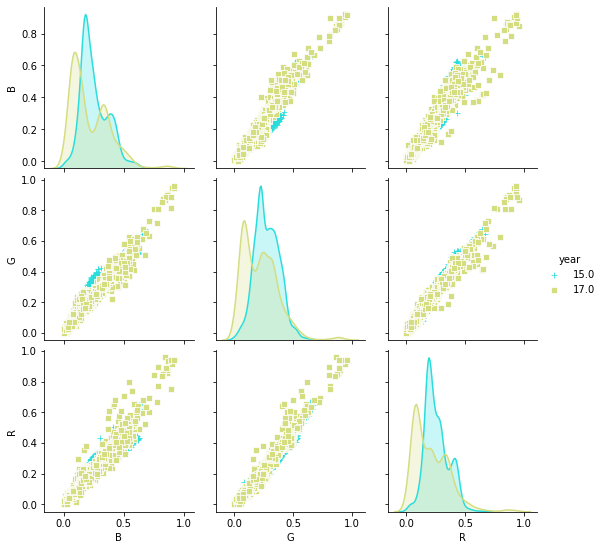

In [77]:
sns.pairplot(df,kind="scatter",diag_kind="kde",hue='year',palette="rainbow",markers=["+", "s"])